In [ ]:
#notebook run on Google Colab
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
image_size = 256 # can we read this from the imagery?

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train, df_val = image_dataset_from_directory('/content/drive/My Drive/Colab Notebooks/imagery',
                                 validation_split = 0.2,
                                 subset='both',
                                 seed = 0,
                                 batch_size = 100,
                                 image_size = (image_size, image_size))
class_names = df_train.class_names
num_classes = len(class_names)
print(class_names)

Found 3901 files belonging to 4 classes.
Using 3121 files for training.
Using 780 files for validation.
['elliptical', 'irregular', 'lenticular', 'spiral']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = df_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
df_val = df_val.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(image_size,
                                  image_size,
                                  3)),
    layers.RandomRotation(0.2),
  ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
epochs=150
patience=8

def train_save_plot_model(model, epochs, patience, df_train, df_val, model_filepath):
  checkpoint_path = "/content/drive/My Drive/Colab Notebooks/models/{}/model_checkpoints/{}.weights.h5".format(model_filepath, model_filepath)
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
  early_stopping = EarlyStopping(
    patience=patience,
    restore_best_weights=True,
    )
  model.compile(optimizer = 'adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  history = model.fit(df_train, validation_data = df_val, epochs=epochs, callbacks=[early_stopping, cp_callback])

  model_path = "/content/drive/My Drive/Colab Notebooks/models/{}/{}.keras".format(model_filepath, model_filepath)
  model.save(model_path)

  history_df = pd.DataFrame(history.history)
  history_df.to_csv('/content/drive/My Drive/Colab Notebooks/models/{}/{}_history.csv'.format(model_filepath, model_filepath))
  history_df.loc[:, ['loss', 'val_loss']].plot();
  return history

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4401 - loss: 1.3542
Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/models/base/model_checkpoints/base.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 298s 9s/step - accuracy: 0.4425 - loss: 1.3477 - val_accuracy: 0.5731 - val_loss: 0.9441
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6108 - loss: 0.9212
Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/models/base/model_checkpoints/base.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.6112 - loss: 0.9199 - val_accuracy: 0.6667 - val_loss: 0.7763
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6234 - loss: 0.8261
Epoch 3: saving model to /content/drive/My Drive/Colab Notebooks/models/base/model_checkpoints/base.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step - accuracy: 0.6237 - loss: 0.8257 - val_accuracy: 0.6513 - val_loss: 0.7579
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.658

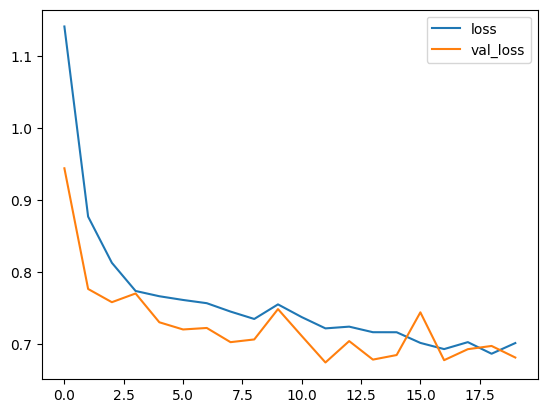

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])
train_save_plot_model(model, epochs, patience, df_train, df_val, 'base')


In [ ]:
# pretrained model (VGG)
VGG = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (image_size, image_size, 3))
VGG.trainable=False

inputs = keras.Input(shape=(image_size, image_size, 3))
x = VGG(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes)(x)

VGGmodel = keras.Model(inputs, outputs)

train_save_plot_model(VGGmodel, epochs, patience, df_train, df_val, 'VGG16_base')

# this suffers from pretty bad overfitting - can't quite figure out how to fix it

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 81s/step - accuracy: 0.4378 - loss: 6.3146  
Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/models/VGG16_base/model_checkpoints/VGG16_base.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3627s 103s/step - accuracy: 0.4382 - loss: 6.2256 - val_accuracy: 0.5397 - val_loss: 1.2965
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 81s/step - accuracy: 0.5413 - loss: 1.2817  
Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/models/VGG16_base/model_checkpoints/VGG16_base.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3262s 102s/step - accuracy: 0.5415 - loss: 1.2809 - val_accuracy: 0.5397 - val_loss: 1.1414
Epoch 3/150
 3/32 ━━━━━━━━━━━━━━━━━━━━ 39:55 83s/step - accuracy: 0.5783 - loss: 1.2031

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4651 - loss: 1.2138
Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/models/more_dropout/model_checkpoints/more_dropout.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 777s 13s/step - accuracy: 0.4675 - loss: 1.2095 - val_accuracy: 0.6321 - val_loss: 0.8427
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6141 - loss: 0.9007
Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/models/more_dropout/model_checkpoints/more_dropout.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 324s 9s/step - accuracy: 0.6143 - loss: 0.9000 - val_accuracy: 0.6615 - val_loss: 0.7850
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6322 - loss: 0.8354
Epoch 3: saving model to /content/drive/My Drive/Colab Notebooks/models/more_dropout/model_checkpoints/more_dropout.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 288s 9s/step - accuracy: 0.6328 - loss: 0.8348 - val_accuracy: 0.6654 - val_loss: 0.7335
Epoch 4/150
32/32 

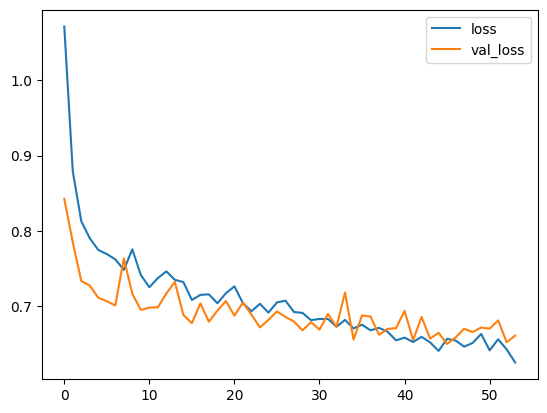

In [ ]:
# more dropout
model3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),
  layers.Dense(num_classes)
])

train_save_plot_model(model3, epochs, patience, df_train, df_val, 'more_dropout')